# Libraries

In [1]:
import csv
import os
import re
import json
import umap

import hdbscan
import numpy as np
import pandas as pd


import matplotlib.pyplot as plt
import matplotlib.colors
from IPython.display import clear_output
from pointgrid import align_points_to_grid

from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

import math
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull
from scipy import interpolate


/opt/homebrew/Caskroom/miniconda/base/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/opt/homebrew/Caskroom/miniconda/base/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/opt/homebrew/Caskroom/miniconda/base/lib/python3.10/site-packag

# Import

## Dataset

In [21]:
articles = pd.read_json('data/fusion.json')

list_orgs = []
list_people = []
list_places = []
list_subjects = []

for index, row in articles.iterrows():

    orgs = row['NER']['ORG']
    people = row['NER']['PERSON']
    places = row['NER']['GPE']

    subjects = []
    for tag in row['tags']:
        if float(tag['score']) > .5:
            subjects.append(tag['label'])

    list_orgs.append(orgs)
    list_people.append(people)
    list_places.append(places)
    list_subjects.append(subjects)

articles['orgs'] = list_orgs
articles['people'] = list_people
articles['places'] = list_places
articles['subjects'] = list_subjects

articles = articles.drop(['tags', 'NER', 'text_content', 'index', 'article'], axis=1)

articles.sample()

,year,title,url,orgs,people,places,subjects
4923,2022,The Low Threshold for Face Recognition in New ...,https://www.wired.com/story/delhi-police-facia...,"[Regulation\nSurveillance, the Internet Freedo...","[Anushka Jain, Divij Joshi, Joshi, Joshi]","[Delhi, India, India, India, Delhi, Delhi, Tel...",[computers and the internet]


## Entities

In [3]:
entities = np.empty((0, 12), dtype=object)

years_template = {}

for year in sorted(set(articles['year'].tolist())):
    years_template[year] = 0


def update(entity, type):  # Function for writing

    global entities
    co = cooccurrences.copy()
    co.remove(entity)
    index = np.where(entities[:, 0] == entity)[0]

    if index.size == 0:
        entities = np.append(
            entities,
            np.array(
                [
                    [
                        entity,
                        type,
                        1,
                        None,
                        None,
                        -1,
                        -1,
                        -1,
                        years_template.copy(),
                        [url],
                        [title],
                        co,
                    ]
                ],
                dtype=object,
            ),
            axis=0,
        )
        entities[len(entities) - 1][8][year] = 1  # Add year
    else:
        entities[index, 2] += 1  # Frequency
        entities[index, 8][0][year] += 1  # Year
        entities[index, 9][0].append(url)  # URL
        entities[index, 10][0].append(title)  # Title
        entities[index, 11][0] += co  # Co-occurrences


for index, row in articles.iterrows():  # Iteration on all the articles

    url = row["url"]
    year = row["year"]
    title = row["title"]
    cooccurrences = list(set(row["subjects"] + row["orgs"] + row["people"]))

    for entity in row["subjects"]:
        update(entity, "subject")

    for entity in row["orgs"]:
        update(entity, "org")

    for entity in row["people"]:
        update(entity, "person")

# Numpy to Pandas

entities_all = pd.DataFrame(
    entities,
    columns=[
        "name",
        "type",
        "frequency",
        "slope",
        "color",
        "x",
        "y",
        "cluster",
        "years",
        "urls",
        "titles",
        "cooccurrences",
    ],
)  # Dataset
entities_all = entities_all.astype(
    {
        "name": "str",
        "type": "str",
        "frequency": "int",
        "slope": "float",
        "color": "str",
        "x": "int",
        "y": "int",
        "cluster": "int",
        "years": "object",
        "urls": "object",
        "titles": "object",
        "cooccurrences": "object",
    }
)


print("The total number of entities is", len(entities))

entities_all.sort_values(by=["frequency"], ascending=False).head(1)


The total number of entities is 69466


,name,type,frequency,slope,color,x,y,cluster,years,urls,titles,cooccurrences
90,Biden,person,6170,NaN,None,-1,-1,-1,"{2013: 0, 2014: 1, 2015: 0, 2016: 0, 2017: 0, ...",[https://www.airforcetimes.com/news/your-air-f...,"[Fewer troops in CENTCOM? No problem, says 3-s...","[Air Forces Central Command, Brad Cooper, Air ..."


# Treatment

## Normalization

In [4]:
# Frequency scale

frequency = entities_all["frequency"].to_numpy().reshape(-1, 1)
min_max_scaler = preprocessing.MinMaxScaler()
frequency_scaled = min_max_scaler.fit_transform(frequency)
entities_all["frequency_norm"] = frequency_scaled

# Transfrom dictionary into JSON

for index, row in entities_all.iterrows():
    entities_all.loc[index, "years_JSON"] = json.dumps(row["years"])

entities_all.sample(1)


,name,type,frequency,slope,color,x,y,cluster,years,urls,titles,cooccurrences,frequency_norm,years_JSON
60171,Juan da Silva,person,1,NaN,None,-1,-1,-1,"{2013: 0, 2014: 0, 2015: 0, 2016: 0, 2017: 0, ...",[https://www.theguardian.com/environment/2022/...,"[Amazon wild west: where drugs, fish and loggi...","[Jair Bolsonaro, Manoel Vítor Sabino da Costa,...",0.0,"{""2013"": 0, ""2014"": 0, ""2015"": 0, ""2016"": 0, ""..."


## Filter

In [11]:
# Number of rows by type

# max_subjects = 1000
# max_orgs = 1000
# max_people = 1000

# top_subjects = (
#     entities_all.loc[entities_all["type"] == "subject"]
#     .sort_values(by=["frequency"], ascending=False)
#     .head(max_subjects)
# )
# top_orgs = (
#     entities_all.loc[entities_all["type"] == "org"]
#     .sort_values(by=["frequency"], ascending=False)
#     .head(max_orgs)
# )
# top_people = (
#     entities_all.loc[entities_all["type"] == "person"]
#     .sort_values(by=["frequency"], ascending=False)
#     .head(max_people)
# )

# entities = pd.concat([top_subjects, top_orgs, top_people])

min_frequency = 50

entities = (
    entities_all[entities_all['frequency']>min_frequency]
    .sort_values(by=["frequency"], ascending=False)
)

len(entities)


748

## Linear Regression

In [12]:
# for each enetity

for i, row in entities.iterrows():

    x = list(row["years"].keys())
    x = np.array(x).reshape((-1, 1))  # needed for one-column values
    y = list(row["years"].values())

    regression = LinearRegression()
    regression.fit(x, y)

    slope = regression.coef_[0] # compute linear regression
    entities.at[i, "slope"] = slope


# normalization by type

scale = 1

for type in entities["type"].unique():

    selection = entities.loc[entities["type"] == type]
    mean = selection["slope"].mean() * scale
    
    for i, row in selection.iterrows():
        entities.at[i, "slope"] = row["slope"] - mean


entities.sample(1)


,name,type,frequency,slope,color,x,y,cluster,years,urls,titles,cooccurrences,frequency_norm,years_JSON
16338,Chen,person,71,-3.948452,None,-1,-1,-1,"{2013: 0, 2014: 0, 2015: 0, 2016: 0, 2017: 0, ...",[https://www.cbsnews.com/miami/news/us-to-issu...,[US to issue ID to migrants awaiting deportati...,"[U.S. Citizenship and Immigration Services, Tr...",0.011347,"{""2013"": 0, ""2014"": 0, ""2015"": 0, ""2016"": 0, ""..."


## Colors

In [13]:
import matplotlib.colors as mcolors

cmap = plt.cm.coolwarm
norm = matplotlib.colors.TwoSlopeNorm(vmin=-1, vcenter=0, vmax=1)

for i, row in entities.iterrows():

    if row["type"] != "subject":
        entities.at[i, "color"] = mcolors.to_hex(cmap(norm(row["slope"])))  # Actors
    else:
        entities.at[i, "color"] = "#cccccc"  # Subjects

# entities.sort_values(by=["slope"], ascending=False).head(1)
entities.head(1)


,name,type,frequency,slope,color,x,y,cluster,years,urls,titles,cooccurrences,frequency_norm,years_JSON
90,Biden,person,6170,216.960639,#b40426,-1,-1,-1,"{2013: 0, 2014: 1, 2015: 0, 2016: 0, 2017: 0, ...",[https://www.airforcetimes.com/news/your-air-f...,"[Fewer troops in CENTCOM? No problem, says 3-s...","[Air Forces Central Command, Brad Cooper, Air ...",1.0,"{""2013"": 0, ""2014"": 1, ""2015"": 0, ""2016"": 0, ""..."


# Embedding

## Term Frequency

In [14]:
vectorizer = CountVectorizer(
    input="content",
    lowercase=False,
    # preprocessor=lambda x: x,
    tokenizer=lambda key: key,
)
words = entities["cooccurrences"].to_list()
X = vectorizer.fit_transform(words)

tfidf = TfidfTransformer(smooth_idf=True, use_idf=True)
tfidf.fit(X)
train_data = tfidf.transform(X)


/opt/homebrew/Caskroom/miniconda/base/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


## UMAP

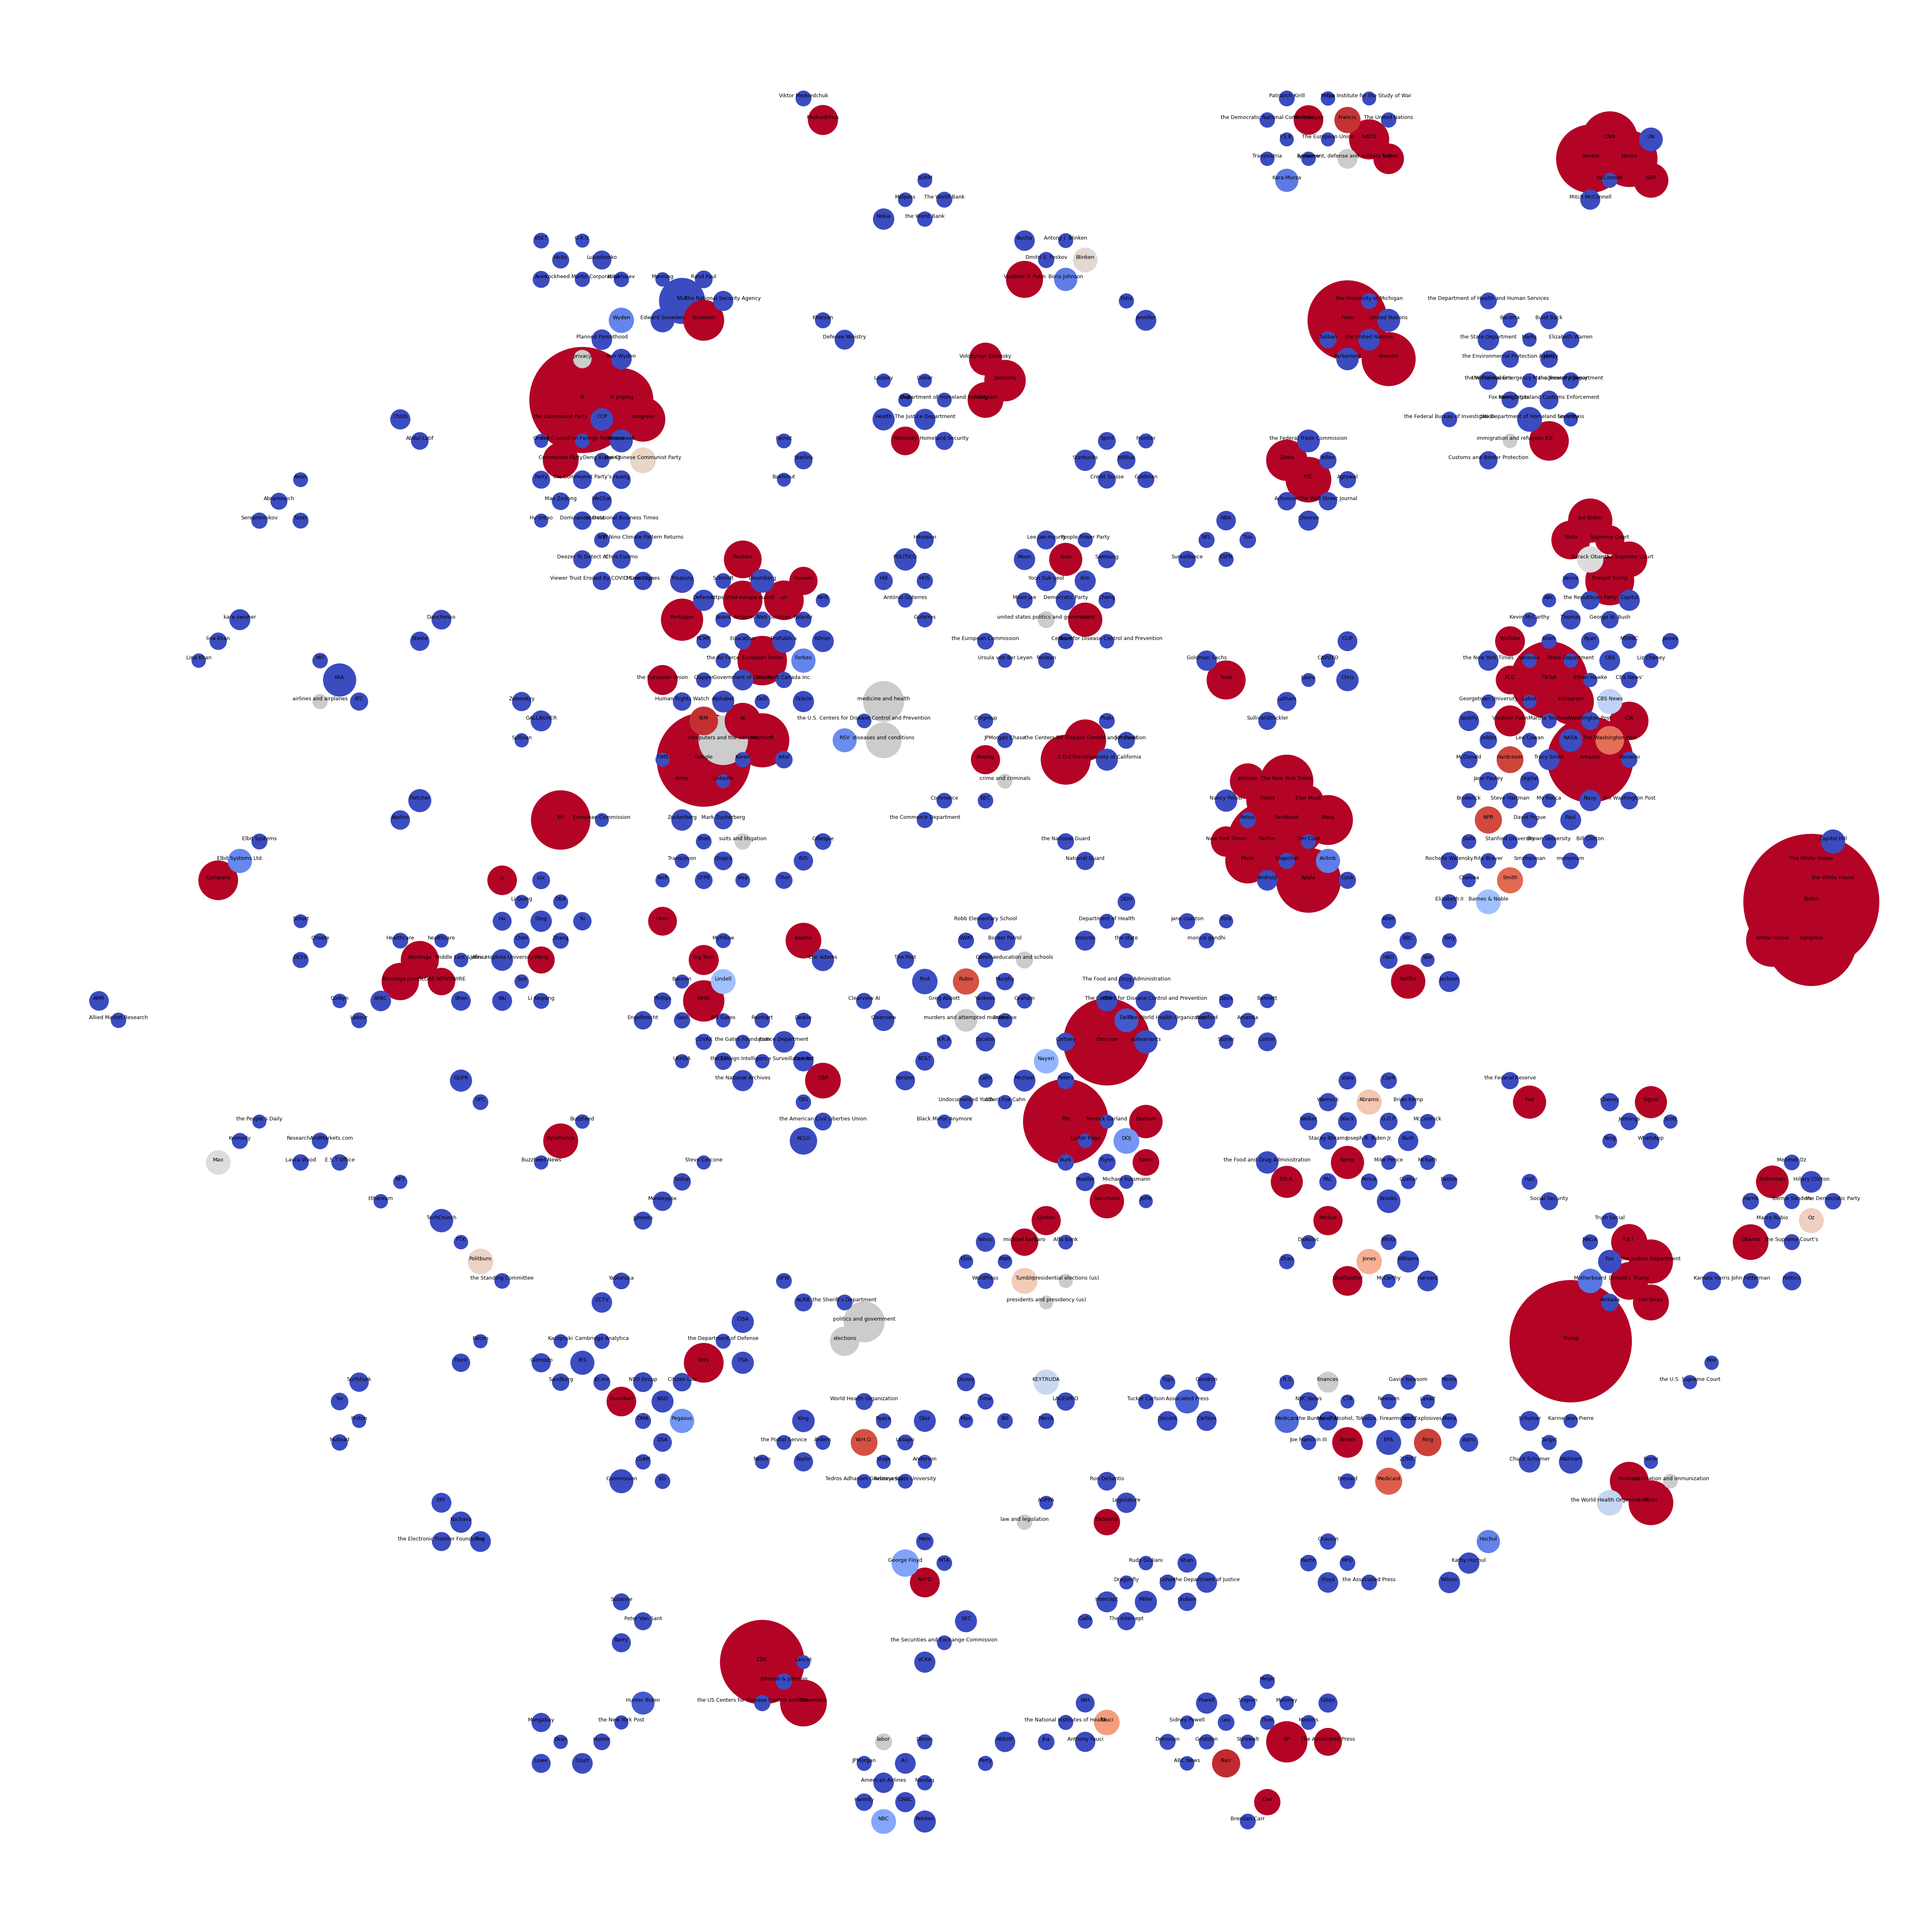

In [15]:
reducer = umap.UMAP(
    random_state=4,
    n_components=2,
    n_neighbors=2,
    min_dist=0.2,
    metric="hellinger",
)

embedding = reducer.fit_transform(train_data)  # Reducer
embedding = align_points_to_grid(embedding)  # Alignment to a grid

scaler = MinMaxScaler(feature_range=(100, 900))  # Scale
embedding = scaler.fit_transform(embedding)
embedding = embedding.astype(int)

index_embedding = 0  # Writing values in the dataset
for index, row in entities.iterrows():
    entities.loc[index, "x"] = embedding[:, 0][index_embedding]
    entities.loc[index, "y"] = embedding[:, 1][index_embedding]
    index_embedding += 1

# entities.sample(1)

plt.figure(figsize=(20, 20), dpi=300)
plt.axis("off")

# Scatterplot

plt.scatter(
    entities["x"].to_list(),
    entities["y"].to_list(),
    s=entities["frequency"].to_list(),
    c=entities["color"].to_list(),
)

# Labels

for i, row in entities.iterrows():
    text = plt.annotate(row["name"], xy=(row["x"], row["y"]), ha="center", va="bottom")
    text.set_fontsize(3)

plt.savefig("download.png")


## Clustering

In [16]:
clusterer = hdbscan.HDBSCAN(
    # min_samples=3,
    min_cluster_size=3,
    # cluster_selection_epsilon=50,   # float, optional (default=0.0) A distance threshold. Clusters below this value will be merged.
    # gen_min_span_tree=False,
    # leaf_size=10, # int, optional (default=40) If using a space tree algorithm (kdtree, or balltree) the number of points ina leaf node of the tree. This does not alter the resulting clustering, but may have an effect on the runtime of the algorithm.
)

entities["cluster"] = "-1"  # Reset


def cluster_computing(rows, prefix, entities):

    embedding = rows[["x", "y"]].to_numpy()
    clusterer.fit(embedding)
    clusters = clusterer.labels_

    # Write cluster number

    for count, (index, row) in enumerate(rows.iterrows()):
        if clusters[count] != -1:
            entities.loc[index, "cluster"] = prefix + str(clusters[count])
        else:
            entities.loc[index, "cluster"] = str(clusters[count])


cluster_computing(
    entities.loc[(entities["type"] != "subject") & (entities["slope"] > 0)],
    "p_",
    entities,
)
cluster_computing(
    entities.loc[(entities["type"] != "subject") & (entities["slope"] < 0)],
    "n_",
    entities,
)

entities.sample(1)


,name,type,frequency,slope,color,x,y,cluster,years,urls,titles,cooccurrences,frequency_norm,years_JSON
13378,Durham,org,343,5.283809,#b40426,583,425,p_10,"{2013: 0, 2014: 0, 2015: 0, 2016: 0, 2017: 4, ...",[https://www.businessinsider.com/trump-special...,[Trump-era special counsel John Durham appeare...,"[James Baker, Robby Mook, William Barr, Donald...",0.055438,"{""2013"": 0, ""2014"": 0, ""2015"": 0, ""2016"": 0, ""..."


{'n_9', 'p_14', 'n_21', 'n_10', 'n_12', 'n_27', 'n_36', 'n_11', 'n_8', 'n_30', 'n_40', 'n_39', 'n_16', 'p_0', 'n_7', 'n_28', 'n_4', 'n_29', 'p_15', 'p_13', 'n_24', 'n_5', 'n_3', 'n_32', 'p_1', 'n_34', 'n_0', 'p_11', 'n_41', 'p_5', 'n_15', 'p_4', 'n_23', 'n_26', 'p_7', 'n_17', 'n_13', 'p_6', 'p_10', 'n_1', 'p_12', 'n_33', 'p_2', 'n_35', 'n_6', 'n_2', 'n_37', 'n_14', 'n_31', 'n_22', 'n_20', 'n_19', 'p_3', 'p_9', 'n_43', '-1', 'n_42', 'n_25', 'p_8', 'n_38', 'n_18', 'n_44'}
10
6
10
17
11
25
3
9
11
15
10
41
4
5
4
4
4
4
10
12
15
5
5
6
5
15
10
8
3
6
7
4
6
5
3
20
5
10
8
10
6
14
4
56
4
5
6
13
11
5
6
24
4
6
16
129
7
6
12
17
6
20


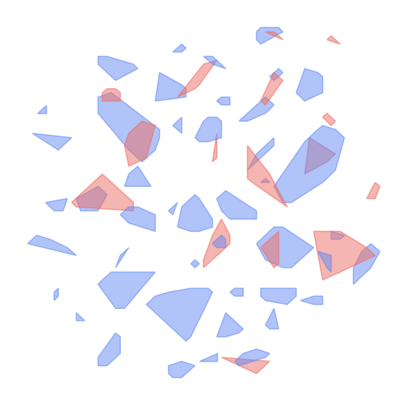

In [17]:
plt.figure(figsize=(5, 5))
plt.axis("off")

clusters = set(entities["cluster"].tolist())

print(clusters)

for counter, cluster in enumerate(clusters):

    points = []  # Points
    rows = entities.loc[entities["cluster"] == cluster]  # Rows

    for index, row in rows.iterrows():
        points.append([row["x"], row["y"]])
    points = np.array(points)

    print(len(points))

    hull = ConvexHull(points)  # Hull
    x_hull = np.append(points[hull.vertices, 0], points[hull.vertices, 0][0])
    y_hull = np.append(points[hull.vertices, 1], points[hull.vertices, 1][0])

    if cluster[0] == "p":
        plt.fill(x_hull, y_hull, "--", c="#ED6D62", alpha=0.5)  # Plot red
    elif cluster[0] == "n":
        plt.fill(x_hull, y_hull, "--", c="#648BF5", alpha=0.5)  # Plot blue


# Save

In [18]:
export = entities.copy()

export = export.drop(columns="years")
export = export.drop(columns="titles")
export = export.drop(columns="cooccurrences")


export.to_csv("src/data/entities.csv", index=False)

export.sample(1)


,name,type,frequency,slope,color,x,y,cluster,urls,frequency_norm,years_JSON
1998,State Department,org,55,-5.0071,#3b4cc0,779,639,n_35,[https://www.arkansasonline.com/news/2022/sep/...,0.008753,"{""2013"": 0, ""2014"": 0, ""2015"": 0, ""2016"": 0, ""..."
